<img src="images/hs-aalen-logo.png"/>

<img src="images/bar.png"/>


# Abschlussbericht Analyseprojekt "Google Reviews Mining"

    Text Mining und Web Analytics 
    Sommersemester 2023
    Christian Wilhelm

Laura Tatlik // Data Science und Business Analytics

<img src="images/Laura.jpg" width="300">

Bastian Rütters // Data Science und Business Analytics

<img src="images/Bastian.jpg" width="300">

Herbi Shtini // Data Science und Business Analytics

<img src="images/Herbi.jpg" width="300">

<img src="images/bar.png">

In [485]:
# NLP-Module
import spacy
from spacy.matcher import Matcher
from spacy.util import minibatch
from spacy.training import Example
from spacy.lang.de.stop_words import STOP_WORDS
from spacy.pipeline.textcat_multilabel import DEFAULT_MULTI_TEXTCAT_MODEL
from wordcloud import WordCloud
from textblob_de import TextBlobDE as TextBlob

# Module zur Datenbearbeitung und Visualisierung
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# Module zur Vorhersagung der neuen Bewertung
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Sontige Module
import numpy as np
import re
import string

import warnings
warnings.filterwarnings("ignore")

In [486]:
nlp = spacy.load('de_core_news_md')
pd.set_option('display.max_colwidth', None)
sns.set_theme()

## Inhaltsverzeichnis

1 Einleitung<br>
2 CRISP-DM<br>
&nbsp;&nbsp;&nbsp;2.1 Business Understanding<br>
&nbsp;&nbsp;&nbsp;2.2 Data Preparation<br>
&nbsp;&nbsp;&nbsp;2.3 Data Understanding<br>
&nbsp;&nbsp;&nbsp;2.4 Modeling<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.4.1 Erster Ansatz mit NLP-TfidfVectorizer<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.4.2 Vorhersage der Bewertung<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.4.3 Bewertung des Ergebnis<br>
&nbsp;&nbsp;&nbsp;2.5 Evaluation<br>
&nbsp;&nbsp;&nbsp;2.6 Deployment<br>
3 Fazit

## 1 Einleitung

Dieser Bericht dient als Ergänzung zu der schriftlichen Ausarbeitung um vor allem den geschriebenen Code in diesem Projekt gut veranschaulichen zu können.

<img src="images/bar.png">

## 2 CRISP-DM
<img src="images/CRISP-DM_klein.png" width="600">

### 2.1 Business Understanding
Nahezu jeder hat sich in Zeiten der Digitalisierung bei der Suche nach einem geeigneten Restaurant oder Lieferdienst, bereits an den Bewertungen im Internet anderer Kunden bedient und anschließend darauf eine Entscheidung für oder gegen eine mögliche Location entschieden. Ob nach der Entscheidung aber genau die eigenen Bedürfnisse entsprechend befriedigt werden, bleibt offen bis zur eigenen Erfahrung. Im folgenden Jupyter Notebook wird die Herangehensweise und Methodik anhand von Code, Codekommentaren und Markdown-Felder erkläutert.

<img src="images/Project_Canvas.jpg" width="1000">

<img src="images/bar.png">

### 2.2 Data Preparation
Die Phase der Datenvorbereitung umfasst alle Aktivitäten zur Erstellung des endgültigen Datensatzes oder der Daten, die aus den anfänglichen Rohdaten in das Modell eingespeist werden. Zu den Aufgaben gehören die Auswahl von Tabellen, Datensätzen und Attributen sowie die Umwandlung und Bereinigung von Daten für das Modell [1].

Die Rohdaten für dieses Projekt werden durch den Scraper (../scrapper/GoogleReviewScrapper.ipynb) von Google Maps extrahiert und als csv-Datei in ../data/reviews.csv gespeichert.

Gescrapt wurden die Bewertungen von 3 Restauraunts/Imbissbuden:

- Super Bros: Pizzaria in Frankfurt am Main
- Dene Gör: Dönerladen in Düsseldorf
- Space Burger: Burgerladen in Düsseldorf

In [487]:
# Einlesen der gescrapten Daten
USE_MANUAL_LABEL = False

REVIEWS_FILE_MANUALLY_LABELED = 'data/reviews_merged_manually_labeled.csv'
REVIEWS_FILE_PATH = 'data/reviews_merged.csv' if USE_MANUAL_LABEL == False else REVIEWS_FILE_MANUALLY_LABELED
REVIEWS_CLEANED_FILE_PATH = 'data/reviews_merged_cleaned.csv'
REVIEWS_CLEANED_UNLABELED_FILE_PATH = 'data/reviews_merged_unlabeled_cleaned.csv'



df = pd.read_csv(REVIEWS_FILE_PATH, sep=';')

In [488]:
all_columns = ['caption',
               'food_positive', 'food_negative',
               'service_positive', 'service_negative',
               'ambient_positive', 'ambient_negative',
               'price_positive', 'price_negative',
               'waiting_positive', 'waiting_negative',
               'rating']
df.columns = all_columns

In [489]:
df.head(3)

,caption,food_positive,food_negative,service_positive,service_negative,ambient_positive,ambient_negative,price_positive,price_negative,waiting_positive,waiting_negative,rating
0,Mega cooles Ambiente und Konzept die Bürger sind auch geschmacklich sehr lecker. Man kann seiner Bürger individuelle auf seine Bedürfnisse anpassen ( Allergien/vegetarisch/Co) …,0,0,0,0,0,0,0,0,0,0,4.0
1,"Super sympathische Mitarbeiter, eine wirklich freundliche und gemütliche Atmosphäre und fantastisches Essen! Wir kommen ganz sicher öfter. …",0,0,0,0,0,0,0,0,0,0,5.0
2,"DAS nenne ich Burger! Nicht so ein Schicki-Micki möchte gerne Burgerladen in Dortmund! *hüstel* Ein absoluter Kult! Maestro del Tozzi - ein Gedicht! Wann immer ich in der Gegend bin, Space Burger oder Lupo. Beides einfach Kult! (Translated by Google) THAT'S what I call burgers! Not such a fancy mic would like a burger shop in Dortmund! *cough* An absolute cult! Maestro del Tozzi - a poem! Whenever I'm in the area, Space Burger or Lupo. Both simply cult!",0,0,0,0,0,0,0,0,0,0,5.0


In [490]:
# Entfernen aller Datenpunkte mit NaN
USEFUL_COLUMNS = ['caption',
                  'food_positive', 'service_positive', 'ambient_positive', 'price_positive', 'waiting_positive', 'rating']
df = df.loc[~df['caption'].isnull(), USEFUL_COLUMNS]

# Indexspalte entfernen
df.reset_index(drop=True)

# Übersicht über bearbeiteten Dataframe
df.head(3)

,caption,food_positive,service_positive,ambient_positive,price_positive,waiting_positive,rating
0,Mega cooles Ambiente und Konzept die Bürger sind auch geschmacklich sehr lecker. Man kann seiner Bürger individuelle auf seine Bedürfnisse anpassen ( Allergien/vegetarisch/Co) …,0,0,0,0,0,4.0
1,"Super sympathische Mitarbeiter, eine wirklich freundliche und gemütliche Atmosphäre und fantastisches Essen! Wir kommen ganz sicher öfter. …",0,0,0,0,0,5.0
2,"DAS nenne ich Burger! Nicht so ein Schicki-Micki möchte gerne Burgerladen in Dortmund! *hüstel* Ein absoluter Kult! Maestro del Tozzi - ein Gedicht! Wann immer ich in der Gegend bin, Space Burger oder Lupo. Beides einfach Kult! (Translated by Google) THAT'S what I call burgers! Not such a fancy mic would like a burger shop in Dortmund! *cough* An absolute cult! Maestro del Tozzi - a poem! Whenever I'm in the area, Space Burger or Lupo. Both simply cult!",0,0,0,0,0,5.0


In [491]:
# Translated by Google aus den Bewertungen entfernen
df['caption'] = df['caption'].str.split('(Translated by Google)').str[0]

# Übersicht über bearbeiteten Dataframe
df.head(3)

,caption,food_positive,service_positive,ambient_positive,price_positive,waiting_positive,rating
0,Mega cooles Ambiente und Konzept die Bürger sind auch geschmacklich sehr lecker. Man kann seiner Bürger individuelle auf seine Bedürfnisse anpassen ( Allergien/vegetarisch/Co) …,0,0,0,0,0,4.0
1,"Super sympathische Mitarbeiter, eine wirklich freundliche und gemütliche Atmosphäre und fantastisches Essen! Wir kommen ganz sicher öfter. …",0,0,0,0,0,5.0
2,"DAS nenne ich Burger! Nicht so ein Schicki-Micki möchte gerne Burgerladen in Dortmund! *hüstel* Ein absoluter Kult! Maestro del Tozzi - ein Gedicht! Wann immer ich in der Gegend bin, Space Burger oder Lupo. Beides einfach Kult! (",0,0,0,0,0,5.0


In [492]:
# Übersicht über Stop-Words in der deutschen Sprache
print(STOP_WORDS)

{'sonst', 'erst', 'nach', 'große', 'jener', 'allgemeinen', 'darunter', 'drin', 'dritter', 'vierter', 'sein', 'jemand', 'manchen', 'meines', 'achten', 'sollten', 'natürlich', 'dann', 'davor', 'mit', 'diejenigen', 'dich', 'wie', 'den', 'grosse', 'der', 'soll', 'erste', 'daher', 'einiges', 'mir', 'wahr', 'welche', 'recht', 'derjenigen', 'ihr', 'geht', 'schon', 'heisst', 'das', 'ganzer', 'ihres', 'kein', 'seit', 'deren', 'sollte', 'wird', 'gedurft', 'siebte', 'weiter', 'will', 'niemandem', 'dieses', 'grosser', 'gehabt', 'solcher', 'kleines', 'möglich', 'wo', 'eine', 'sieben', 'gute', 'früher', 'etwas', 'seitdem', 'ich', 'solches', 'wessen', 'niemand', 'jeder', 'dürft', 'mag', 'nicht', 'gar', 'meinen', 'worden', 'beispiel', 'fünften', 'zweiten', 'oft', 'denen', 'dieser', 'darin', 'manche', 'rechtes', 'weil', 'zunächst', 'ihre', 'siebente', 'einer', 'tag', 'keine', 'gemusst', 'wollte', 'zweite', 'dementsprechend', 'unsere', 'willst', 'en', 'sagt', 'zwei', 'dabei', 'leider', 'mein', 'als', 'n

In [493]:
REGX_USERNAME = r"@[A-Za-z0-9$-_@.&+]+"
REGX_URL = r"https?://[A-Za-z0-9./]+"
def preprocessing(text):
    text = text.lower()

    # Benutzernamen und URLs aus dem Text entfernen
    text = re.sub(REGX_USERNAME, ' ', text)
    text = re.sub(REGX_URL, ' ', text)

    # Emojis durch Text ersetzen
    emojis = {
        ':)': 'positive emotionen',
        ':(': 'negative emotionen'
    }

    for e in emojis:
        text = text.replace(e, emojis[e])
        
    # Tokenisiere den Text mit dem SpaCy-Modell
    tokens = [token.text for token in nlp(text)]

    # Entferne Stoppwörter, Interpunktion und Wörter mit weniger als 3 Zeichen.
    tokens = [t for t in tokens if
              t not in STOP_WORDS and
              t not in string.punctuation and
              len(t) > 3]
    
    # Zahlen aus dem Text entfernen
    tokens = [t for t in tokens if not t.isdigit()]
    
    text = " ".join(tokens);

    # Lemmatisierung
    '''
    allowed_postags = ["NOUN", "ADJ", "VERB", "ADV"]
    doc = nlp(text)
    new_text = []
    for token in doc:
        if token.pos_ in allowed_postags:
            new_text.append(token.lemma_)
    lemmatized = " ".join(new_text).lower()
    '''
    return text

In [494]:
# Funktion "preprocessing" auf die Spalte "caption" anwenden und in die neue Spalte "caption_clean" hinzufügen
df["caption_clean"] = df["caption"].apply(preprocessing)

# df Dataframe
USEFUL_COLUMNS_AND_CLEAN = USEFUL_COLUMNS[:]
# Die Spalte 'caption' wird zu diesem Zeitpunkt nicht ausgewählt,
# stattdessen wird 'caption_clean' genommen.
USEFUL_COLUMNS_AND_CLEAN.remove('caption')
USEFUL_COLUMNS_AND_CLEAN.append('caption_clean') # Select caption_clean


df = df[USEFUL_COLUMNS_AND_CLEAN]

# Die Spalte 'caption_clean' jetzt mit 'caption' ersetzen
df = df.rename(columns={"caption_clean": "caption"}) #
USEFUL_COLUMNS_AND_CLEAN.append('caption') # add caption
USEFUL_COLUMNS_AND_CLEAN.remove('caption_clean') # Remove caption_clean
df.reset_index(drop=True)

,food_positive,service_positive,ambient_positive,price_positive,waiting_positive,rating,caption
0,0,0,0,0,0,4.0,mega cooles ambiente konzept bürger geschmacklich lecker bürger individuelle bedürfnisse anpassen allergien vegetarisch
1,0,0,0,0,0,5.0,super sympathische mitarbeiter freundliche gemütliche atmosphäre fantastisches essen sicher öfter
2,0,0,0,0,0,5.0,nenne burger schicki-micki gerne burgerladen dortmund hüstel absoluter kult maestro tozzi gedicht gegend space burger lupo beides einfach kult
3,0,0,0,0,0,1.0,gestern dritt selben burger bestellt gestern abend magen darm burger lecker irgendetwas schmeckte komisch erwartet
4,0,0,0,0,0,4.0,fanden burger restaurant klasse individuelle möglichkeiten zudem fleischlose alternativen ambiente zeitsprung vergangenheit kartenzahlung heutzutage zeitgemäß
...,...,...,...,...,...,...,...
354,0,0,0,0,0,5.0,hervorragende neapolitanische pizza
355,0,0,0,0,0,5.0,staff super fruendliche atmosphäre chillig schöne auswahl pizzas lecker schnell fertig wartezeit qalität leidet
356,0,0,0,0,0,5.0,leckere pizza hochpreisig
357,0,0,0,0,0,5.0,amazing pizza


In [495]:
# Übersicht über bearbeitete Daten
df.head(3)

,food_positive,service_positive,ambient_positive,price_positive,waiting_positive,rating,caption
0,0,0,0,0,0,4.0,mega cooles ambiente konzept bürger geschmacklich lecker bürger individuelle bedürfnisse anpassen allergien vegetarisch
1,0,0,0,0,0,5.0,super sympathische mitarbeiter freundliche gemütliche atmosphäre fantastisches essen sicher öfter
2,0,0,0,0,0,5.0,nenne burger schicki-micki gerne burgerladen dortmund hüstel absoluter kult maestro tozzi gedicht gegend space burger lupo beides einfach kult


In [496]:
# Erneutes löschen der NaN Werte in bearbeiteten Spalten
df = df.loc[~df['caption'].isnull(), USEFUL_COLUMNS_AND_CLEAN]
df = df[df['caption'].str.strip().astype(bool)]

In [497]:
# Übersicht über die Spalte mit dem Text
df['caption'].head()

0                                           mega cooles ambiente konzept bürger geschmacklich lecker bürger individuelle bedürfnisse anpassen allergien vegetarisch
1                                                                 super sympathische mitarbeiter freundliche gemütliche atmosphäre fantastisches essen sicher öfter
2                    nenne burger schicki-micki gerne burgerladen dortmund hüstel absoluter kult maestro tozzi gedicht gegend space burger lupo beides einfach kult
3                                                gestern dritt selben burger bestellt gestern abend magen darm burger lecker irgendetwas schmeckte komisch erwartet
4    fanden burger restaurant klasse individuelle möglichkeiten zudem fleischlose alternativen ambiente zeitsprung vergangenheit kartenzahlung heutzutage zeitgemäß
Name: caption, dtype: object

In [498]:
# Dataframe als csv-Datei abspeichern
df[['caption', 'rating']].to_csv(REVIEWS_CLEANED_UNLABELED_FILE_PATH, sep=';')
df.to_csv(REVIEWS_CLEANED_FILE_PATH, sep=';')

#### Labeling

In [499]:
df = pd.read_csv(REVIEWS_CLEANED_UNLABELED_FILE_PATH, sep=';')
df.head()

,Unnamed: 0,caption,rating
0,0,mega cooles ambiente konzept bürger geschmacklich lecker bürger individuelle bedürfnisse anpassen allergien vegetarisch,4.0
1,1,super sympathische mitarbeiter freundliche gemütliche atmosphäre fantastisches essen sicher öfter,5.0
2,2,nenne burger schicki-micki gerne burgerladen dortmund hüstel absoluter kult maestro tozzi gedicht gegend space burger lupo beides einfach kult,5.0
3,3,gestern dritt selben burger bestellt gestern abend magen darm burger lecker irgendetwas schmeckte komisch erwartet,1.0
4,4,fanden burger restaurant klasse individuelle möglichkeiten zudem fleischlose alternativen ambiente zeitsprung vergangenheit kartenzahlung heutzutage zeitgemäß,4.0


In [500]:
categories = ['essen', 'service', 'atmosphäre', 'preis', 'warten']
categories_columns = ['food_positive', 'food_negative',
                      'service_positive', 'service_negative',
                      'ambient_positive', 'ambient_negative',
                      'price_positive', 'price_negative',
                      'waiting_positive', 'waiting_negative']

In [501]:
def spacy_most_similar(word, topn=10):
    """
    Diese Funktion gibt eine Liste von Wörtern zurück, die den Eingabewortvektor von spaCy am ähnlichsten sind. 

    Argumente:
        - word (str): Das Wort, für das die ähnlichsten Wörter gefunden werden sollen
        - topn (int): Die Anzahl der ähnlichsten Wörter, die zurückgegeben werden sollen (Standardwert: 10)

    Rückgabewert:
        - words (list): Eine Liste von Wörtern, die den Eingabewortvektor von spaCy am ähnlichsten sind
        - distances (list): Eine Liste von Distanzen zwischen den ähnlichsten Wörtern und dem Eingabewortvektor    
    """

    ms = nlp.vocab.vectors.most_similar(
        nlp(word).vector.reshape(1,nlp(word).vector.shape[0]), n=topn)
    words = [nlp.vocab.strings[w] for w in ms[0][0]]
    distances = ms[2]
    return words, distances

In [502]:
spacy_most_similar(categories[0])

(['Aufessen',
  'weggefuttert',
  'drinken',
  'einzukochen',
  'koten',
  'inhaliere',
  'knabbere',
  'Bio-Essen',
  'schmatz',
  'Trinket'],
 array([[1.    , 0.8243, 0.8131, 0.7734, 0.7115, 0.7059, 0.7032, 0.6845,
         0.672 , 0.6681]], dtype=float32))

#### Aspektbasierte Stimmungsanalyse

Folgender Code sucht in den Texten des "caption"-Felds eines Dataframes nach bestimmten Mustern (patterns), verwendet dabei den Matcher von spaCy und bestimmt für jede Übereinstimmung eine passende Kategorie basierend auf der Ähnlichkeit des gefundenen Textes mit vordefinierten Kategorien. Gefundene Übereinstimmungen werden mit ihrer Kategorie und ihrem Index im ursprünglichen Dataframe in einem neuen Dataframe namens "df_matches" gespeichert und ausgegeben.

In [503]:
matcher = Matcher(nlp.vocab)
patterns = [
    [{'POS':'ADJ', 'OP': '+'}, {'POS':'NOUN'}],
    [{'POS':'NOUN'}, {'POS':'VERB'}, {'POS':'ADJ'}]
]
matcher.add("category", patterns)

df_matches = pd.DataFrame([], columns=['index', 'aspect', 'entity_group'])

similarity_min = 0.4

for rowIndex, wordText in enumerate(df['caption']):
    doc = nlp(wordText)
    matches = matcher(doc)

    for match_id, start, end in matches:
        string_id = nlp.vocab.strings[match_id]
        span = doc[start:end]

        for i, s in enumerate(span):
            if s.pos_ in ['NOUN']:
                category = ''
                similarity = 0

                similarity_cat0 = nlp(categories[0]).similarity(span)
                if similarity_cat0 > similarity_min: # fits into
                    category = categories[0]
                    similarity = similarity_cat0

                print(span)
                similarity_cat1 = nlp(categories[1]).similarity(span)
                if similarity_cat1 > similarity_min: # fits into
                    category = categories[1]
                    similarity = similarity_cat1

                similarity_cat2 = nlp(categories[2]).similarity(span)
                if similarity_cat2 > similarity_min: # fits into
                    category = categories[2]
                    similarity = similarity_cat2

                similarity_cat3 = nlp(categories[3]).similarity(span)
                if similarity_cat3 > similarity_min: # fits into
                    category = categories[3]
                    similarity = similarity_cat3

                similarity_cat4 = nlp(categories[4]).similarity(span)
                if similarity_cat4 > similarity_min: # fits into
                    category = categories[4]
                    similarity = similarity_cat4

                df_matches = pd.concat([pd.DataFrame({'index': rowIndex,
                                                      'aspect': category,
                                                      'entity_group': span.text,
                                                      }, columns=df_matches.columns, index=[0]),
                                        df_matches])

ambiente konzept
cooles ambiente konzept
lecker bürger
individuelle bedürfnisse
sympathische mitarbeiter
gemütliche atmosphäre
freundliche gemütliche atmosphäre
fantastisches essen
burger schicki-micki
absoluter kult
burger lupo
selben burger
individuelle möglichkeiten
ambiente zeitsprung
alternativen ambiente zeitsprung
fleischlose alternativen ambiente zeitsprung
bester service
lecker burger
fairen preis
ambiente kartenzahlung
coolen ambiente kartenzahlung
leckere burger
freundliche bedienung
klasse auswahl
milchshake kombination
sterne milchshake kombination
veganer vegetarier
bescheidenen services
kreative auswahl
schlechten erfahrungen
tolle atmosphäre
leckere burger
leckere burger
nette bedienung
burger d-dorf
handgemachte burger
lecker gast
tische minuten
kalter burger
nettes personal
erstklassige burger
witziges ambiente
lieblingslokale stadt
eingerichtetes restaurant
lockeren servicemitarbeitern
größer sparmenüs
versteckte kamera
cooles ambiente
fairen preisen
bester burger
ba

In [504]:
df_matches

,index,aspect,entity_group
0,332,,jüngere volk
0,330,essen,leckere pizza
0,329,,schöne auswahl
0,329,atmosphäre,fruendliche atmosphäre
0,328,,hervorragende neapolitanische pizza
...,...,...,...
0,1,atmosphäre,sympathische mitarbeiter
0,0,,individuelle bedürfnisse
0,0,essen,lecker bürger
0,0,atmosphäre,cooles ambiente konzept


####  TextBlob Stimmungsanalyse

In [505]:
# Initialisierung von zwei leeren Listen
sentiment_polarities = []
sentiment_subjectivities = []

# Iteration durch jede Zeile des Dataframes "df_matches"
for i, row in df_matches.iterrows():
    # Berechnung des Sentiments (Polarität und Subjektivität) des entity_groups-Texts mit TextBlob
    sentiment = TextBlob(row['entity_group']).sentiment
    # Hinzufügen der Polarität des Sentiments zur sentiment_polarities-Liste
    sentiment_polarities.append(sentiment.polarity)
    # Hinzufügen der Subjektivität des Sentiments zur sentiment_subjectivities-Liste
    sentiment_subjectivities.append(sentiment.subjectivity)

# Hinzufügen der Spalten "sentiment_polarity" und "sentiment_subjectivity" zum df_matches-Dataframe 
df_matches['sentiment_polarity'] = sentiment_polarities
df_matches['sentiment_subjectivity'] = sentiment_subjectivities

# Sortierung des df_matches-Dataframes nach dem Index der ursprünglichen Zeilen
df_matches_sorted = df_matches.sort_values(by='index')
# Ausgabe des df_matches_sorted-Dataframes
print(df_matches_sorted)

   index      aspect                         entity_group  sentiment_polarity  \
0      0  atmosphäre                     ambiente konzept                 0.0   
0      0                         individuelle bedürfnisse                 0.0   
0      0  atmosphäre              cooles ambiente konzept                 0.7   
0      0       essen                        lecker bürger                 0.0   
0      1       essen                  fantastisches essen                 1.0   
..   ...         ...                                  ...                 ...   
0    328              hervorragende neapolitanische pizza                 1.0   
0    329  atmosphäre               fruendliche atmosphäre                 0.0   
0    329                                   schöne auswahl                 1.0   
0    330       essen                        leckere pizza                 0.0   
0    332                                     jüngere volk                 0.0   

    sentiment_subjectivity 

In [506]:
df.head(3)

,Unnamed: 0,caption,rating
0,0,mega cooles ambiente konzept bürger geschmacklich lecker bürger individuelle bedürfnisse anpassen allergien vegetarisch,4.0
1,1,super sympathische mitarbeiter freundliche gemütliche atmosphäre fantastisches essen sicher öfter,5.0
2,2,nenne burger schicki-micki gerne burgerladen dortmund hüstel absoluter kult maestro tozzi gedicht gegend space burger lupo beides einfach kult,5.0


In [507]:
# Durch alle df_matches laufen
# Prüft für jeden Index den Aspekt, ob er einer Kategorie entspricht
# Aktualisiert die richtige Kategorie von df mit der jeweiligen Stimmung
if not USE_MANUAL_LABEL:
    for column in categories_columns:
        df[column] = 0

    for rowIndex, row in df.iterrows():
        entities_by_index = df_matches_sorted.loc[df_matches_sorted['index'] == rowIndex]
        # reset
        for j, item in entities_by_index.iterrows():
            if item['aspect'] != '':
                category_i = categories.index(item['aspect'])
                polarity = item['sentiment_polarity']
                if polarity != 0:
                    column_index = (category_i * 2) if polarity > 0 else (category_i * 2) + 1
                    df.at[rowIndex, categories_columns[column_index]] = 1

df.head(2)

,Unnamed: 0,caption,rating,food_positive,food_negative,service_positive,service_negative,ambient_positive,ambient_negative,price_positive,price_negative,waiting_positive,waiting_negative
0,0,mega cooles ambiente konzept bürger geschmacklich lecker bürger individuelle bedürfnisse anpassen allergien vegetarisch,4.0,0,0,0,0,1,0,0,0,0,0
1,1,super sympathische mitarbeiter freundliche gemütliche atmosphäre fantastisches essen sicher öfter,5.0,1,0,0,0,1,0,0,0,0,0


In [508]:
df.to_csv(REVIEWS_CLEANED_FILE_PATH, sep=';')

<img src="images/bar.png">

### 2.3 Data Understanding
Die zweite Phase im CIRSP-DM Model, das Data Understanding, ist der Schritt, in dem man Daten aus verschiedenen Quellen sammelt, aufbereitet, untersucht, relevante Daten für die Analyse auswählt, Datenziele anpasst, mögliche Datenprobleme identifiziert und ein besseres Verständnis der Daten erhält, um fundierte Entscheidungen für die weitere Analyse treffen zu können [1].

In [509]:
# Relativen Pfad definieren
REVIEWS_CLEANED_FILE_PATH = 'data/reviews_merged_cleaned.csv'

# Einlesen der bearbeiteten Daten
df = pd.read_csv(REVIEWS_CLEANED_FILE_PATH, sep=';')

In [510]:
# Alle Bewertungen in einen langen String joinen
full_caption_text = '. '.join(df['caption'])
len(full_caption_text)

24746

In [511]:
# Funktion um die meist genutzten Wörter zu ermitteln
def getWordFrequency(text, pos="NOUN", top_items=0):
    doc = nlp(text)
    words = [token.lemma_
             for token in doc
             if (not token.is_stop and not token.is_punct and (pos == "" or token.pos_ == pos))]
    word_freq = Counter(words)

    return(dict(word_freq.most_common(top_items) if top_items else word_freq.most_common()))

#### Anzahl der Google-Bewertungen pro Bewertungsgruppe

[Text(0.5, 0, 'Bewertung'), Text(0, 0.5, 'Zahl')]

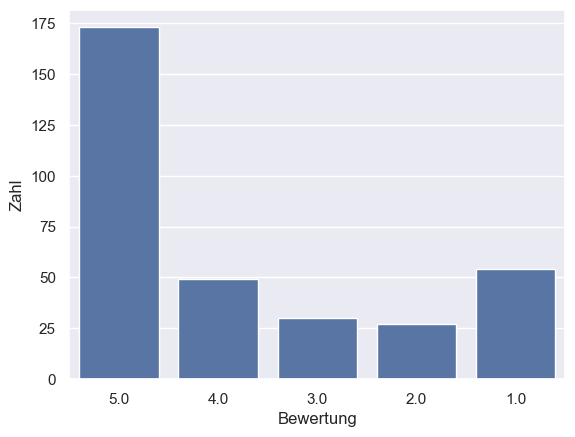

In [512]:
# Axen initialisieren
f, ax = plt.subplots(1,1)
# Ermitteln der Anzahl der Sterne-Bewertungen
ratings = df['rating'].value_counts().reset_index()
# Spalten definieren
ratings.columns = ['rating', 'count']
# Abstiegend sortieren
ratings = ratings.sort_values(by=['rating'], ascending=False)
# Barplot erstellen
sns.barplot(data=ratings, x="rating", y='count', color='b', ax=ax, order=ratings['rating'])
ax.set(xlabel='Bewertung', ylabel='Zahl')

####  Meistverwendete Wörter

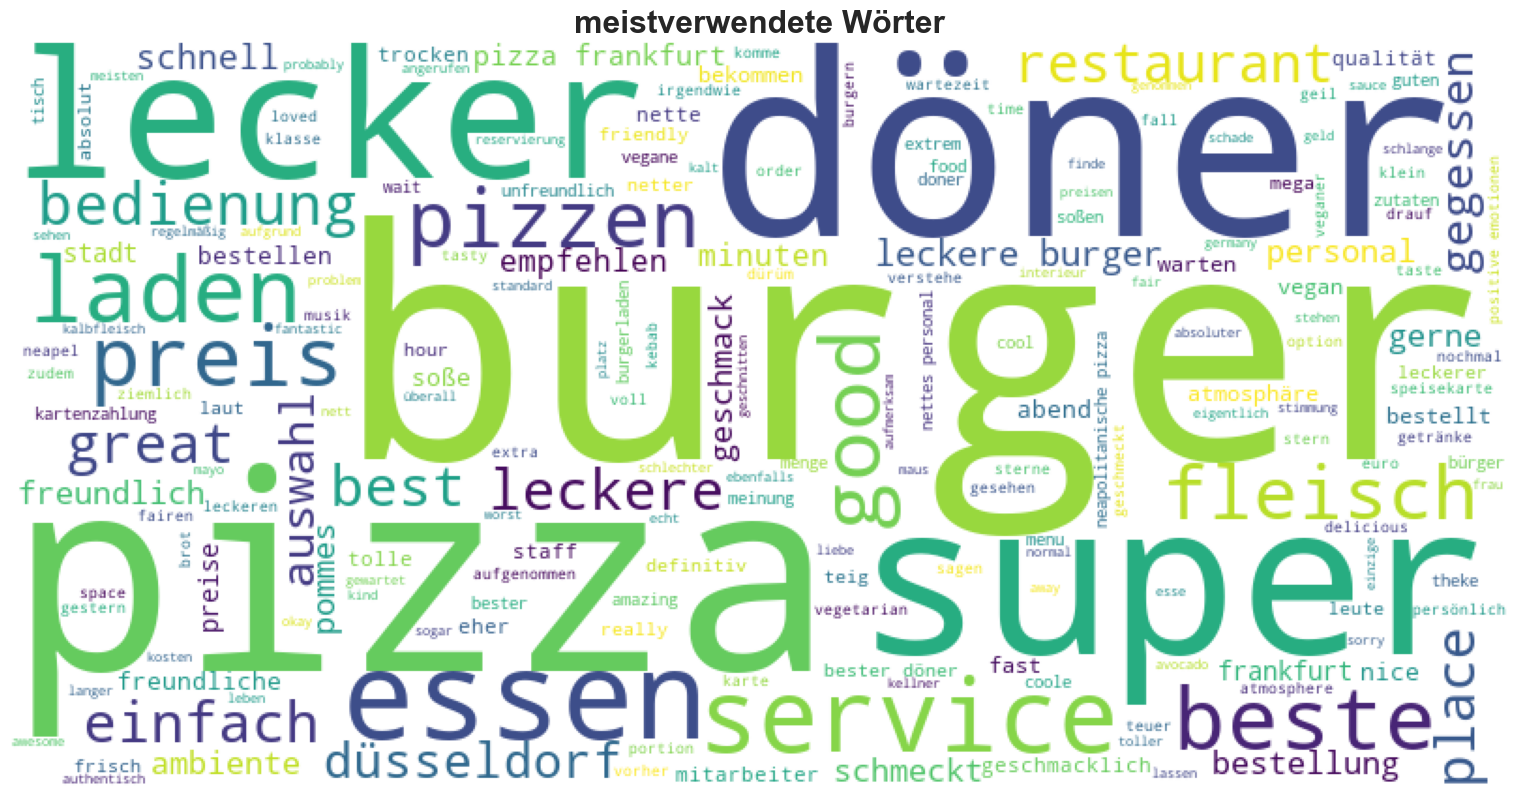

In [513]:
# WordCloud-Diagramm der am häufigsten verwendeten Wörter erstellen
plt.figure(figsize=(15, 12), facecolor = None)
plt.imshow(WordCloud(width = 800, height = 400,
                     background_color='white').generate( full_caption_text ))
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('meistverwendete Wörter', fontsize=23, fontweight='bold')
plt.show()

#### Meistverwendete Nomen & Verben

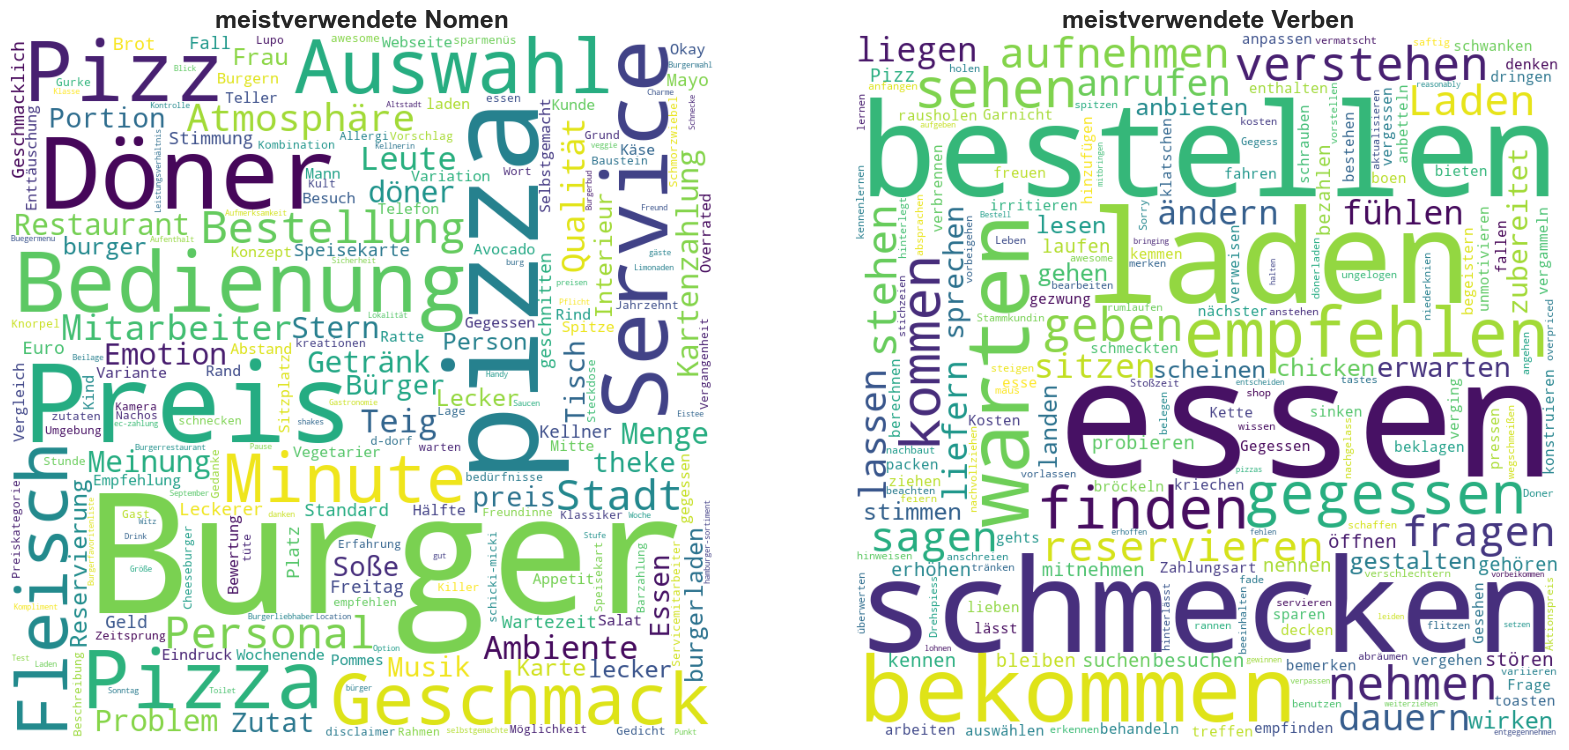

In [514]:
# Erstellung meistverwendeten Nomen und Verben
freqNoun = getWordFrequency(full_caption_text, "NOUN")
freqVerb = getWordFrequency(full_caption_text, "VERB")

# Erstellung der Variablen "freqs" und "titles", um die Häufigkeit von Nomen und Verben darzustellen.
freqs = [freqNoun, freqVerb]
titles = ['meistverwendete Nomen', 'meistverwendete Verben']

# WordCloud-Diagramm mit 2 Subplots
f, axes = plt.subplots(1,2)
f.set_figheight(15)
f.set_figwidth(20)
for i, ax in enumerate(axes):
    ax.imshow(WordCloud(width = 800, height = 800,
                        background_color='white').generate_from_frequencies( freqs[i] ))
    ax.axis('off')
    ax.set_title(titles[i], fontsize=18, fontweight='bold')

In [515]:
# Funktionszuweisung - freq
freq = getWordFrequency(full_caption_text, "NOUN")

#### Meisteverwendete Verben pro Bewertung

In [516]:
# Bewertungen der jeweiligen Sterne-Kategorien in String-Format joinen
full_caption_text_1 = '. '.join(df.loc[df['rating'] == 1]['caption'])
full_caption_text_2 = '. '.join(df.loc[df['rating'] == 2]['caption'])
full_caption_text_3 = '. '.join(df.loc[df['rating'] == 3]['caption'])
full_caption_text_4 = '. '.join(df.loc[df['rating'] == 4]['caption'])
full_caption_text_5 = '. '.join(df.loc[df['rating'] == 5]['caption'])

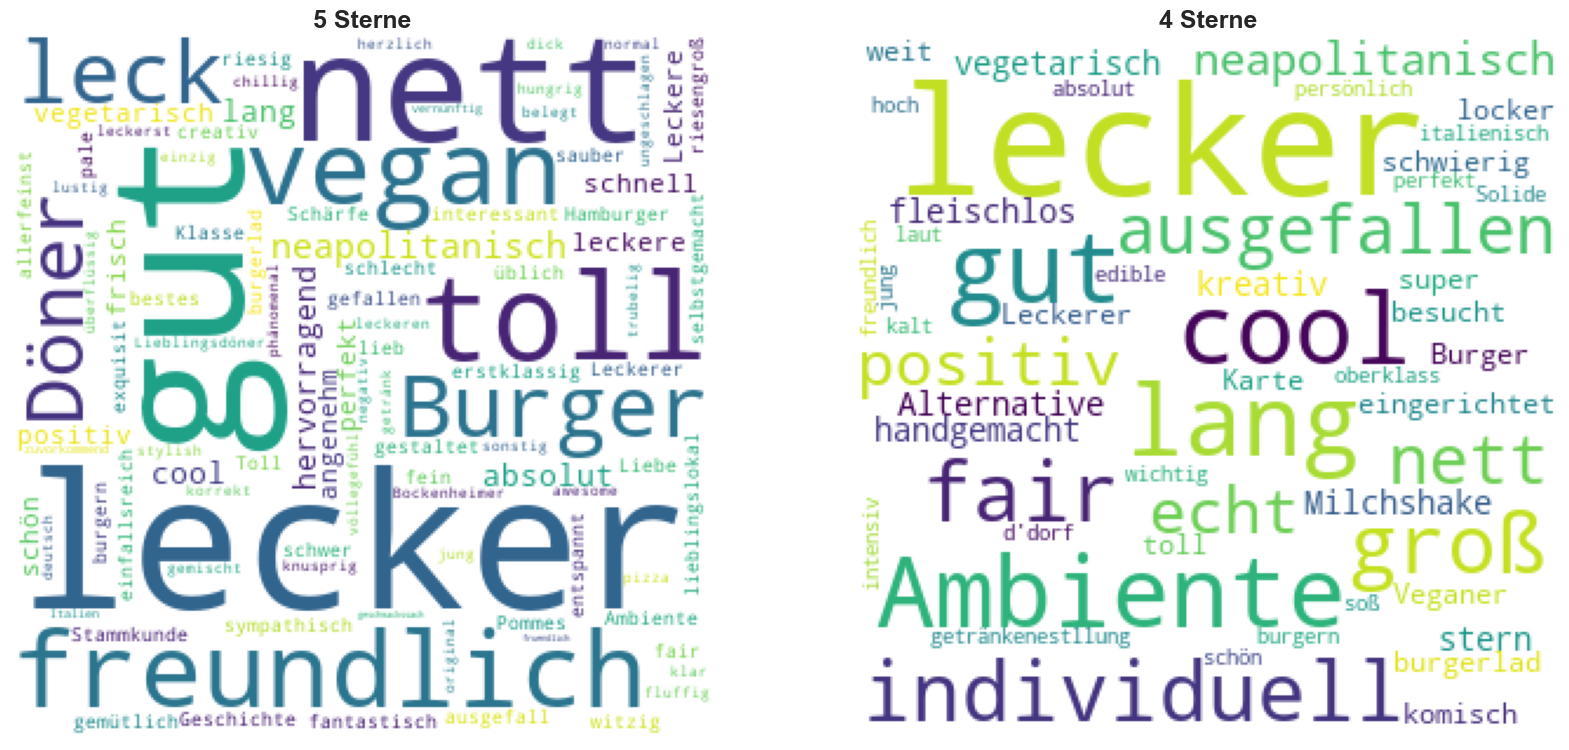

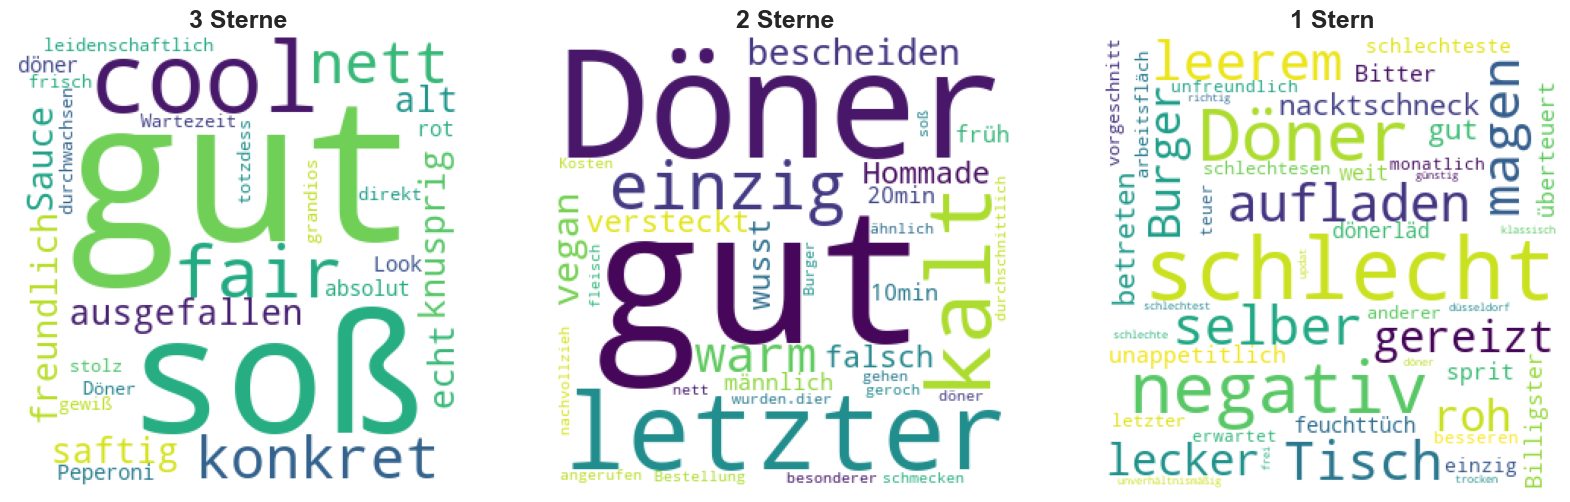

In [517]:
# Berechnung der Häufigkeit von Adjektiven im Text mit 5 und 4 Sternen Bewertung
freqs1 = [ getWordFrequency(full_caption_text_5, "ADJ"),
           getWordFrequency(full_caption_text_4, "ADJ")]

# Berechnung der Häufigkeit von Adjektiven im Text mit 3, 2 und 1 Sternen Bewertung
freqs2 = [getWordFrequency(full_caption_text_3, "ADJ"),
          getWordFrequency(full_caption_text_2, "ADJ"),
          getWordFrequency(full_caption_text_1, "ADJ")]

# Titel für das Wordcloud-Diagramm
titles1 = ['5 Sterne', '4 Sterne']
titles2 = ['3 Sterne', '2 Sterne', '1 Stern']

# Erstellung von zwei Subplots mit einer Spalte und zwei bzw. drei Zeilen.
f1, axes1 = plt.subplots(1, 2)
f2, axes2 = plt.subplots(1, 3)

# Plotgröße ändern
f1.set_figheight(15)
f1.set_figwidth(20)

# Plotgröße ändern
f2.set_figheight(15)
f2.set_figwidth(20)

# Erstellung der WordCloud-Diagramme für Texte mit 5 und 4 Sterne Bewertung
for i, ax in enumerate(axes1):
    ax.imshow(WordCloud(width = 300, height = 300,
                        background_color='white').generate_from_frequencies( freqs1[i] ))
    ax.axis('off')
    ax.set_title(titles1[i], fontsize=18, fontweight='bold')

# Erstellung der WordCloud-Diagramme für Texte mit 3, 2 und 1 Sterne Bewertung
for i, ax in enumerate(axes2):
    ax.imshow(WordCloud(width = 300, height = 300,
                        background_color='white').generate_from_frequencies( freqs2[i] ))
    ax.axis('off')
    ax.set_title(titles2[i], fontsize=18, fontweight='bold')

<img src="images/bar.png">

### 2.4 Modeling
In der vierten Phase des CRISP-DM Modell, dem Modeling, werden verschiedene Modellierungstechniken evaluiert. Es wird überprüft, welche Technik für das jeweilige Data-Mining-Problem am besten anwendbar ist. Hier müssen gegebenenfalls die Schritte der Datenvorbereitung wiederholt werden. Neben der Auswahl der Modellierungstechnik und der eigentlichen Modellierung wird oder werden die Modelle am Ende dieser Phase ebenfalls nach verschiedenen Kriterien bewertet und in den Kontext des Data-Mining-Problems eingeordnet [1].

Für die spätere Bewertung werden bei Klassifizierungsproblemen, wie dies, welches in diesem Projekt vorliegt, Fehlerraten als Qualitätsmaßstab genutzt. Um eine verzerrungsfreie Evaluierung sicherstellen zu können, müssen die Daten in ein Trainings- und einem Testdatensatz getrennt werden. Die Modellierung beruht dann auf dem Trainingsdatensatz und wird mithilfe des Testdatensatzes die Qualität der Vorhersage geschätzt [1].

#### 2.4.1 Erster Ansatz mit NLP-TfidfVectorizer

In [518]:
# Selbsterstellte Bewertungen mit Label

trainingsdata = pd.read_csv(REVIEWS_FILE_MANUALLY_LABELED, sep=';')
trainingsdata.columns = all_columns

Die gesäuberten Daten wurden manuell mit den verschiedenen Kategorien gelabelt.

In [519]:
# Übersicht über die Daten
trainingsdata.iloc[:,1:].head(2)

,food_positive,food_negative,service_positive,service_negative,ambient_positive,ambient_negative,price_positive,price_negative,waiting_positive,waiting_negative,rating
0,1,0,0,0,0,0,0,0,0,0,4.0
1,1,0,1,0,1,0,0,0,0,0,5.0


In [520]:
# Funktion zum Trainieren und Anwenden des Textklassifikationsmodells definieren
def nlp_tfidfvectorizer(data, category, text):
    
    # Ausschnitt der Spalte "caption" und Funktions-Parameter
    subset_train = data[['caption', category]]
    # Ausschnitt in eine Liste von Tuples konventieren
    train_data = list(subset_train.itertuples(index=False, name=None))
    
    # Trainingsdaten (Beispiele von Texten, die manuell in die verschiedenen Kategorien eingeteilt wurden)
    training_data = train_data
    
    # Pipeline, die aus einem TfidfVectorizer und einem LinearSVC-Modell besteht
    model = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('svc', LinearSVC())
    ])

    # Modell auf den Trainingsdaten trainieren
    model.fit([text for text, category in training_data], [category for text, category in training_data])

    # Vorhersage der Kategorie
    predicted_category = model.predict([text])
    
    return predicted_category[0] if predicted_category else 0

In obiger Funktion wird eine Pipeline erstellt, die einen Text in ein maschinenlesbares Format umwandelt und dann eine lineare SVM verwendet, um die Textdaten zu klassifizieren. Die Intention dieser Funktion ist eine automatische Zuordnung von Texten zu bestimmten Kategorien auf der Grundlage eines trainierten Modells.

In [521]:
# Vorhersagen für die Kategorie Essen
print(f"Actually: 1, Predictet: {nlp_tfidfvectorizer(trainingsdata, 'food_positive', 'Das Essen war gut')}")
print(f"Actually: 0, Predictet: {nlp_tfidfvectorizer(trainingsdata, 'food_positive', 'Es hat nicht geschmeckt')}")
print(f"Actually: 0, Predictet: {nlp_tfidfvectorizer(trainingsdata, 'food_positive', 'Schlechtes Essen')}")
print(f"Actually: 1, Predictet: {nlp_tfidfvectorizer(trainingsdata, 'food_positive', 'Es war köstlich')}")
print(f"Actually: 0, Predictet: {nlp_tfidfvectorizer(trainingsdata, 'food_positive', 'Es war schlimm')}")
print("...")

Actually: 1, Predictet: 1
Actually: 0, Predictet: 0
Actually: 0, Predictet: 1
Actually: 1, Predictet: 0
Actually: 0, Predictet: 0
...


In [522]:
# Vorhersagen für die Kategorie Service
print(f"Actually: 1, Predictet: {nlp_tfidfvectorizer(trainingsdata, 'service_positive', 'Super freundlich')}")
print(f"Actually: 0, Predictet: {nlp_tfidfvectorizer(trainingsdata, 'service_positive', 'Unfreundliche Bedienung')}")
print(f"Actually: 0, Predictet: {nlp_tfidfvectorizer(trainingsdata, 'service_positive', 'Die Bedienung war sehr unfreundlich')}")
print(f"Actually: 1, Predictet: {nlp_tfidfvectorizer(trainingsdata, 'service_positive', 'Die Bedienung war sehr freundlich')}")
print(f"Actually: 0, Predictet: {nlp_tfidfvectorizer(trainingsdata, 'service_positive', 'Das Essen war sehr lecker, doch die Bedienung war nicht freundlich')}")
print("...")

Actually: 1, Predictet: 1
Actually: 0, Predictet: 0
Actually: 0, Predictet: 0
Actually: 1, Predictet: 1
Actually: 0, Predictet: 1
...


In [523]:
# Vorhersagen für die Kategorie Ambiente
print(f"Actually: 1, Predictet: {nlp_tfidfvectorizer(trainingsdata, 'ambient_positive', 'Schönes Ambiente')}")
print(f"Actually: 0, Predictet: {nlp_tfidfvectorizer(trainingsdata, 'ambient_positive', 'Kein schönes Ambiente')}")
print(f"Actually: 1, Predictet: {nlp_tfidfvectorizer(trainingsdata, 'ambient_positive', 'Das Ambiente war schön')}")
print(f"Actually: 1, Predictet: {nlp_tfidfvectorizer(trainingsdata, 'ambient_positive', 'Wir haben uns sehr wohl gefühlt')}")
print(f"Actually: 0, Predictet: {nlp_tfidfvectorizer(trainingsdata, 'ambient_positive', 'Das Essen war sehr lecker, doch das Ambiente war nicht schön')}")
print("...")

Actually: 1, Predictet: 1
Actually: 0, Predictet: 1
Actually: 1, Predictet: 1
Actually: 1, Predictet: 0
Actually: 0, Predictet: 0
...


Es ist festzustellen, dass der Umfang des Trainingsdatensatzes zu gering ist um eine gute Vorhersage eines Textes zu erzeugen. Die Vorhersagen in den Unterschiedlichen Kategorien sind vielversprechend, wenn der Text aus wenigen Wörtern besteht und nicht Teil eines komplexen Satzes ist. Aufgrund dessen wird dieser Ansatz verworfen und im nächsten Abschnitt ein Model implementiert, welches die Bewertungen selbst labeln kann. 

#### 2.4.2 Vorhersage der Bewertung
Nachdem die gescrapten Bewertungen mithilfe des Models gelabelt wurden, dienen diese Daten nun als Trainingsdaten für eine multiple lineare Regression. 

Zur Vorhersage der Bewertung werden verschiedene Modelle getestet, darunter multiple-lineare Regression, Random-Forest-Regression und ein Textcat-Modell. Das am besten geeignete Modell wird ausgewählt, um die spezifischen Vorgaben zu erfüllen und eine Vorhersage über eine neue Bewertung zu treffen

#### Multiple lineare Regression

In [524]:
# Dataframe der maschinell gelabelten Daten einlesen
labeld_data = pd.read_csv(REVIEWS_CLEANED_FILE_PATH, sep=';') # Gelabelte Daten von Textcat Modell

In [525]:
# Benötigte Spalte definieren
data_predict = labeld_data.iloc[:, 2:]

In [526]:
# Prädiktoren und Zielvariable definieren
X = data_predict.iloc[:, 2:]
y = data_predict["rating"]

In [527]:
# NaN-Werte mit 0 füllen
X.fillna(0, inplace=True)

In [528]:
# Datensatz in Trainings- und Testdaten aufteilen
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 101)

In [529]:
# Lineare Regressionsmodell initialisieren
model = LinearRegression()

In [530]:
# Model auf die Trainingsdaten fitten
model.fit(X_train, y_train)

LinearRegression()

In [531]:
# Vorhersagen treffen
predicitions = model.predict(X_test)

In [532]:
data_predict.iloc[:, 2:]

,food_positive,food_negative,service_positive,service_negative,ambient_positive,ambient_negative,price_positive,price_negative,waiting_positive,waiting_negative
0,0,0,0,0,1,0,0,0,0,0
1,1,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
328,0,0,0,0,0,0,0,0,0,0
329,0,0,0,0,0,0,0,0,0,0
330,0,0,0,0,0,0,0,0,0,0
331,0,0,0,0,0,0,0,0,0,0


In [533]:
# Evaluation des Modells

In [534]:
# Eingabe der gewünschten Kategorien und Vorhersage der neuen Bewertung
# Anwender ist gutes Essen wichtig (Index 0 = 1)
# Anwender ist guter Service egal (Index 2 = 0)
# Anwender ist ein gutes Ambiente wichtig (Index 4 = 0)
# Anwender ist ein angemessener Preis wichtig (Index 6 = 1)
# Anwender ist eine lange Wartezeit egal (Index 8 = 0)
neue_bewertung = model.predict(np.array([1, 0, 0, 0, 1, 0, 1, 0, 0, 0]).reshape(1, -1))

In [535]:
# Neue Bewertung gemäß der gewünschten Kriterien
print(f"Die neue Bewertung beträgt: {round(neue_bewertung[0], 2)} Sterne")

Die neue Bewertung beträgt: 4.04 Sterne


#### Random Forest Regression

In [536]:
# Erstellen des RandomForest-Regression-Modells mit 100 Bäumen
rf = RandomForestRegressor(n_estimators=100, random_state=42)

In [537]:
# Anpassen des Modells an die Trainingsdaten
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [538]:
# Vorhersagen auf den Testdaten durchführen
y_pred = rf.predict(X_test)

In [539]:
# Berechnen der mittleren quadratischen Abweichung (MSE) des Modells
mse = mean_squared_error(y_test, y_pred)

In [540]:
# Ausgabe des MSE des Modells
print("MSE:", mse)

MSE: 2.2148077730060702


In [541]:
# Eingabe der gewünschten Kategorien und Vorhersage der neuen Bewertung
# Anwender ist gutes Essen wichtig (Index 0 = 1)
# Anwender ist guter Service egal (Index 2 = 0)
# Anwender ist ein gutes Ambiente wichtig (Index 4 = 0)
# Anwender ist ein angemessener Preis wichtig (Index 6 = 1)
# Anwender ist eine lange Wartezeit egal (Index 8 = 0)
vorhersage = rf.predict(np.array([1, 0, 0, 0, 1, 0, 1, 0, 0, 0]).reshape(1, -1))

# Ausgabe der Vorhersage
print(f"Vorhersage: {round(vorhersage[0], 2)} Sterne")

Vorhersage: 3.83 Sterne


#### NLP-textcat_multilabel

In [542]:
nlp_blank = spacy.blank("de")

In [543]:
df = pd.read_csv(REVIEWS_CLEANED_FILE_PATH, sep=';')
df.head()

,Unnamed: 0.1,Unnamed: 0,caption,rating,food_positive,food_negative,service_positive,service_negative,ambient_positive,ambient_negative,price_positive,price_negative,waiting_positive,waiting_negative
0,0,0,mega cooles ambiente konzept bürger geschmacklich lecker bürger individuelle bedürfnisse anpassen allergien vegetarisch,4.0,0,0,0,0,1,0,0,0,0,0
1,1,1,super sympathische mitarbeiter freundliche gemütliche atmosphäre fantastisches essen sicher öfter,5.0,1,0,0,0,1,0,0,0,0,0
2,2,2,nenne burger schicki-micki gerne burgerladen dortmund hüstel absoluter kult maestro tozzi gedicht gegend space burger lupo beides einfach kult,5.0,0,0,0,0,0,0,0,0,0,0
3,3,3,gestern dritt selben burger bestellt gestern abend magen darm burger lecker irgendetwas schmeckte komisch erwartet,1.0,0,0,0,0,0,0,0,0,0,0
4,4,4,fanden burger restaurant klasse individuelle möglichkeiten zudem fleischlose alternativen ambiente zeitsprung vergangenheit kartenzahlung heutzutage zeitgemäß,4.0,0,0,0,0,0,0,0,0,0,0


In [544]:
# Iteration durch jede Zeile des Dataframes
for _, row in df.iterrows():
    # Zuweisung der "caption"-Spalte der Variable text
    text = row["caption"]
    # Zuweisung der "rating"-Spalte der Variable rating
    rating = row["rating"]

    # Liste von Spaltennamen, die später als Kategorien verwendet werden sollen
    target_columns = ['1', '2', '3', '4', '5']

    # Doc-Object erstellen
    doc = nlp_blank(text)

    # Iterieration durch jede Spalte in der target_columns-Liste
    for column in target_columns:
        # Überprüfung auf Übereinstimmung
        doc.cats[column] = (rating == int(column))

In [545]:
# Objekt zur spacy-Pipeline hinzufügen
textcat_multilabel = nlp_blank.add_pipe("textcat_multilabel", config={
    "threshold": 0.5,
    "model": DEFAULT_MULTI_TEXTCAT_MODEL,
}, last=True)

# alle 5 Labels hinzufügen
for column in target_columns:
    textcat_multilabel.add_label(column)

In [546]:
df['rating'].head()

0    4.0
1    5.0
2    5.0
3    1.0
4    4.0
Name: rating, dtype: float64

In [547]:
# Funktion zur Aufteilung in Trainings- und Testsets
def load_data(split=0.8):
    # Index, an dem die Daten in Trainings- und Testsets aufgeteilt werden
    split = int(len(df) * split)

    X_train = df['caption'][:split]
    y_train = df['rating'][:split]

    X_test = df['caption'][split:]
    y_test = df['rating'][split:]

    # Gib die Trainings- und Testdaten als Tupel zurück
    return (X_train, y_train), (X_test, y_test)

In [548]:
# Laden der Trainings- und Testdaten mithilfe der "load_data"-Funktion
(X_train, y_train), (X_test, y_test) = load_data()

# X_train Kategorie Zuweisung
train_data = list(zip(X_train, [{'cats': {
    column: (int(column) == int(rating)) for column in target_columns
}
} for index, rating in enumerate(y_train)]))

# X_test Kategorie Zuweisung
test_data = list(zip(X_test, [{'cats': {
    column: int(column) == int(rating) for column in target_columns
}
} for index, rating in enumerate(y_test)]))

In [549]:
train_data[:2]

[('mega cooles ambiente konzept bürger geschmacklich lecker bürger individuelle bedürfnisse anpassen allergien vegetarisch',
  {'cats': {'1': False, '2': False, '3': False, '4': True, '5': False}}),
 ('super sympathische mitarbeiter freundliche gemütliche atmosphäre fantastisches essen sicher öfter',
  {'cats': {'1': False, '2': False, '3': False, '4': False, '5': True}})]

In [550]:
# TextCategorizer trainieren
other_pipes = [pipe for pipe in nlp_blank.pipe_names if pipe != 'textcat_multilabel']

with nlp_blank.disable_pipes(*other_pipes):
    optimizer = nlp_blank.initialize()
    # Die Gewichte werden 100 Iterationen lang ständig aktualisiert.
    for i in range(100): # Iterations
        losses = {}
        np.random.shuffle(train_data)
        for batch in minibatch(train_data, size=8):
            for text, annotations in batch:
                # Example erstellen
                doc = nlp_blank.make_doc(text)
                example = Example.from_dict(doc, annotations)
                # Das Modell aktualisieren
                nlp_blank.update([example], drop=0.3, sgd=optimizer, losses=losses)

In [551]:
# Die Bewertung des Models
correct = 0
total = 0
accuracies = []

for index, row in enumerate(test_data):
    text = row[0]
    annotations = row[1]

    doc = nlp_blank(text)
    scores = textcat_multilabel.predict([doc])

    item_accuracies = []
    for i, key in enumerate(target_columns):
        isSame = annotations['cats'][key] == round(scores[0][i])
        item_accuracies.append(1 if isSame else 0)

    score_item_accuracy = np.array(item_accuracies).sum() / len(target_columns)
    accuracies.append(score_item_accuracy)

accuracy = np.array(accuracies).sum() / len(accuracies)
print(f"Genauigkeit: {round(accuracy * 100, 2)}%")

Genauigkeit: 89.25%


In [552]:
text = 'Die Staff sind super fruendliche und die Atmosphäre ist chillig. Es gibt eine Schöne Auswahl an Pizzas, die richtig lecker sind. Alles wird schnell fertig gemacht, ohne lange Wartezeit und ohne das die Qalität leidet.'
prediction = textcat_multilabel.predict([nlp_blank(text)])
df_prediction = pd.DataFrame(prediction)
df_prediction.columns = [1, 2, 3, 4, 5]
df_prediction

,1,2,3,4,5
0,0.000673,0.000057,0.000275,0.002805,0.997736


#### 2.4.3 Bewertung der Ergebnis
Random Forest Regression ist besser für Daten mit nicht-linearen Zusammenhängen, Robustheit gegen Ausreißer und kann wichtige Variablen identifizieren, aber es ist schwierig zu interpretieren. Die direkte Vorhersage von Bewertungen anhand von Texten war für das Projekt ungeeignet, da das Ziel darin bestand, einen Zusammenhang der Bewertungen zu bestimmten Kategorien wie Qualität des Essens, Service und Preis-Leistungsverhältnis zu finden. Obwohl Random-Forest-Regression schwer zu interpretieren ist, bietet es die beste Vorhersage und die automatisierte Kategorisierung kann die Interpretierbarkeit des Modells verbessern. Multiple Lineare Regression ist bei nicht-linearen Zusammenhängen ungenau und fehleranfällig.


<img src="images/bar.png">

### 2.5 Evaluation
Bei der Phase der Evaluation wird überprüft, ob die Zielsetzung des Data-Mining-Projekts erreicht wurde. Hierbei werden die Resultate der Modellierung und das Vorgehen bzw. der Prozess der Informationsgewinnung bewertet. Falls das Ergebnis hier deutlich negativ ausfällt, ist zu überprüfen, ob es gegebenenfalls einen erneuten Durchlauf des CRISP-DM-Modells benötigt. Zum Schluss werden die nächsten Schritte bzw. die Schritte für as Deployment festgelegt [1].

<img src="images/bar.png">

### 2.6 Deployment
Das Deployment kann über verschiedene Weg stattfinden. Ein anwenderfreundlicher Weg wäre z.B. der Zugriff über ein Streamlit-Dashboard.

Hierbei kann der Anwender den Link zum Google-Maps Eintrag des gewünschten Restaurants zur Verfügung stellen und im Anschluss die Kriterien auswählen, die zur neu Berechnung der Bewertung genutzt werden sollen.

<img src="images/bar.png">

## 3 Fazit
Die Auswertung von Google Bewertungen gestaltete sich als äußerst schwierig, da die Texte sehr individuell und oft in Umgangssprache verfasst wurden. Die Erstellung geeigneter Trainingsdaten für eine automatische Analyse ist mit viel Aufwand verbunden. Die automatisierte Kategorisierung mit Spacy war die effektivste Methode, um große Mengen an Bewertungen schnell zu kategorisieren und manuelle Überprüfungen zu reduzieren. Die direkte Vorhersage von Bewertungen mithilfe von Textcat erwies sich ebenfalls als schwierig und erfordert tiefes Verständnis von Sprachstrukturen und Kontext. Das erstellte Modell auf Basis des automatisierten Labeling mithilfe von Matcher und TextBlob sowie die Vorhersage mittels Random-Forest-Regression erbrachte die besten Ergebnisse, ist jedoch bzgl. der Zuverlässigkeit der Vorhersagen mit befriedigend zu bewerten. 

<br> Die Analyse von Google Bewertungen ist eine komplexe Aufgabe, die viel Wissen und Erfahrung in der Sprachverarbeitung und Datenanalyse erfordert. Es müssen die Grenzen der Automatisierung berücksichtigt werden, und der Verzicht einer menschlichen Überprüfung, um genaue Ergebnisse zu erzielen, ist in diesem Projekt nicht gelungen.

<img src="images/bar.png">

## 4 Quellen

[1] Shearer, C. (2000) The CRISP-DM Model: The New Blueprint for Data Mining. Journal of Data Warehousing, 5, 17.
<br> [2] Marangon, J. (2022, 7. November), Building a Text Classification model with spaCy 3.x. Medium. Online-Vorveröffentlichung. https://medium.com/@johnidouglasmarangon/building-a-text-classification-model-with-spacy-3-x-57e59fa50547
<br> [3] Mattingly, W. (2022), Topic Modeling: Concepts and Theory. Python Humanities. Online-Vorveröffentlichung. http://python-textbook.pythonhumanities.com/04_topic_modeling/04_01_01_intro.html
<br> [4] Pattakos, A. (2021, 28. Februar), Aspect-Based Sentiment Analysis Using Spacy & TextBlob. Towards Data Science. Online-Vorveröffentlichung. https://towardsdatascience.com/aspect-based-sentiment-analysis-using-spacy-textblob-4c8de3e0d2b9
